<a href="https://colab.research.google.com/github/Clement-Moreau-Info/Enseignements/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutoriel BRED Datascience -- Clustering

Ce tutoriel est dédié à la manipulation et à l'analyse des principaux algorithmes et techniques d'apprentissage non supervisée (i.e., clustering). 

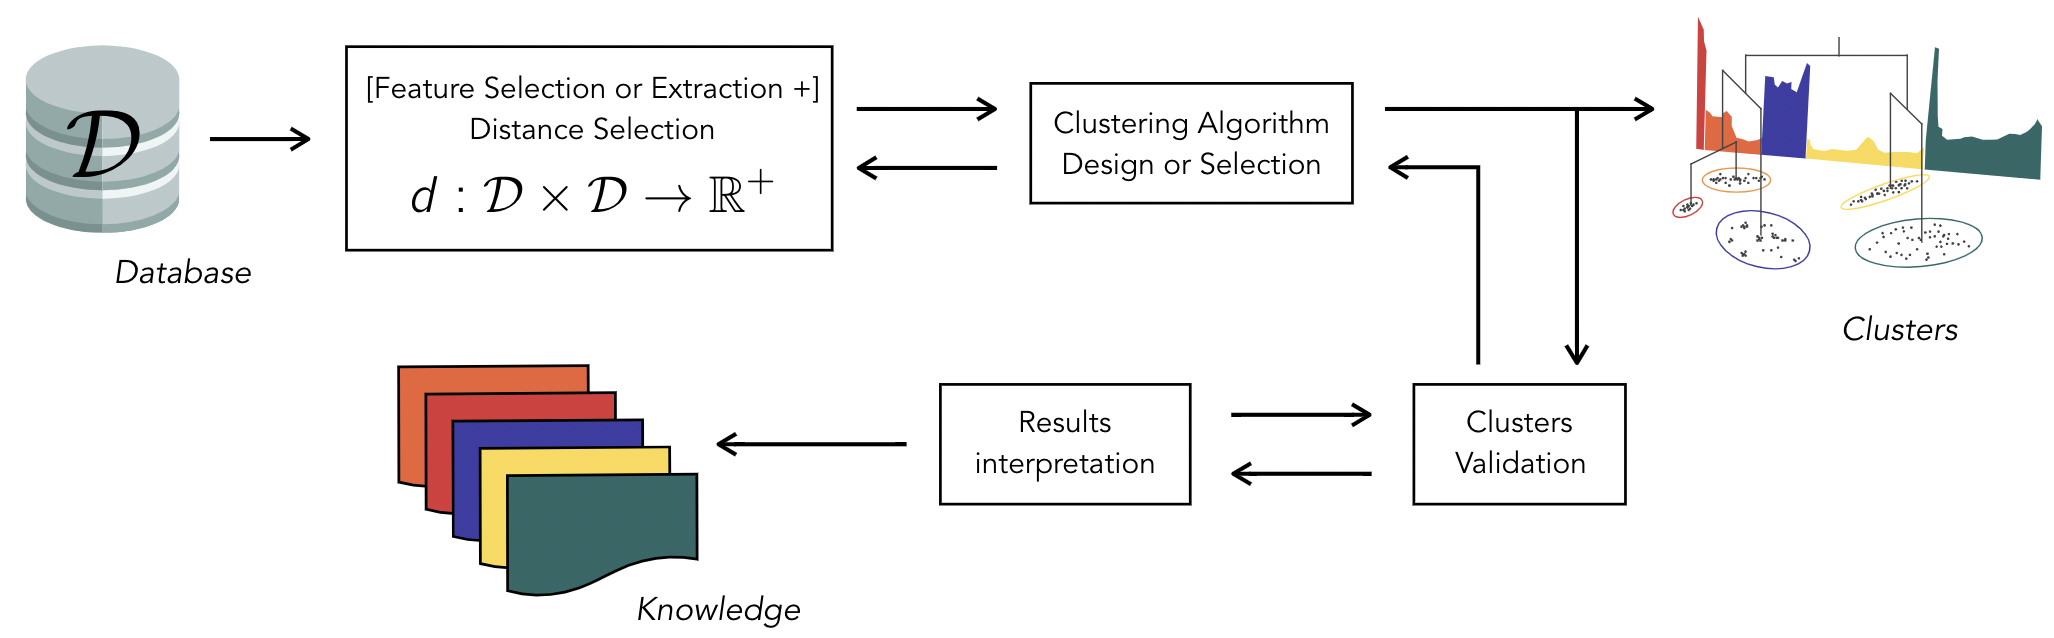

Comme illustré sur la figure ci-dessus tirée de l'article [Survey of clustering algorithms](https://scholarsmine.mst.edu/cgi/viewcontent.cgi?article=1763&context=ele_comeng_facwork) (Xu et Wush, 2005), le processus de clustering se déroule en **4 grandes étapes** : 

1. La sélection de la distance
2. La sélection de l'algorithme de clustering
3. La validation des cluster à l'aide d'une mesure de qualité
4. L'interprétation des clusters

Dans ce tutoriel, nous aborderons majoritairement les étapes 2 et 3. 

En conséquence, et sauf indication contraire, nous manipulerons des jeux de données numériques telles que $\mathcal{D} \subset \mathbb{R}^n$ et utiliserons la distance euclidienne comme distance par défaut telle que : 

$$||x-y|| = \sqrt{\sum_{i=1}^n (x_i - y_i)^2}$$

avec $x,y \in \mathbb{R}^n$, deux vecteurs numériques de dimensions $n$. 

## Importation des librairies

In [ ]:
import numpy as np
import pandas as pd
from sklearn import cluster, datasets, metrics
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Couleurs pour les clusters
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 10)

## K-means clustering

On considère notre ensemble de données $\mathcal{D}$ (avec $|\mathcal{D}| = n$) l'ensemble des points du plan suivants : 

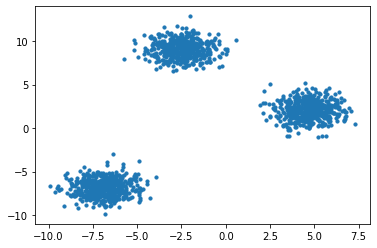

In [ ]:
n_samples = 1500

blobs = datasets.make_blobs(n_samples=n_samples, random_state=42)
X, y = blobs
plt.scatter(X[:, 0], X[:, 1],  s=10)

<font color='blue'>
<i>
<b>
1. Visuellement, combien de clusters  identifiez-vous ?
</b>
</i>
</font>

> Afin de regrouper nos différents ensemble de points, nous proposons de mettre en place un premier algorithme, [K-means](https://en.wikipedia.org/wiki/K-means_clustering). 
>
> Pour rappel, le principe de K-means consiste à initialiser $k$ centres de gravité $\mu_{i\in[\![1,k]\!]}$, de manière aléatoire et assigner au cluster $C_i$, à chaque itération, tous les objets $x \in \mathcal{D}$ tel que $\mu_i$ est le plus proche. 
>
> Les $\mu_i$ sont ensuite affinés en recalculant leurs coordonnées pour les $x\in C_i$. Ainsi, l’objectif de K-means est de minimiser la fonction :
> 
> $$\sum_{i=1}^K \sum_{x\in C_i} ||x-\mu_i||^2$$
>
> La convergence de l’algorithme est assurée car le centre de gravité est l’objet qui minimise l’inertie intra-cluster. Par le théorème de Huygens, cela revient aussi à maximiser l’inertie inter-classe.

------

**Point technique** 

- L'algorithme K-means est incapable de traiter des clusters de formes concaves.
- La complexité de K-means est en $O(n \times k \times iter)$ (où $iter$ est le nombre d'itérations de l'algorithme).

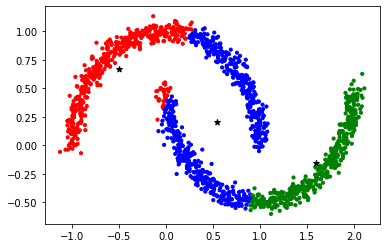

In [ ]:
from sklearn.cluster import KMeans

# Nombre de clusters K à rentrer 
K = 3

algorithm = KMeans(n_clusters=K) 
f = algorithm.fit(X)
y_pred = algorithm.predict(X)

# Affichage des clusters
plt.scatter(X[:, 0], X[:, 1], s=10, color = colors[y_pred])
# Ajout des centres de gravité
plt.scatter(x=f.cluster_centers_[:,0], y=f.cluster_centers_[:,1], color='black', marker='*')

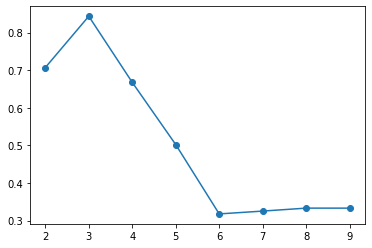

In [ ]:
from sklearn.metrics import silhouette_score

sil = []
for k in range(2,10):
    algorithm = KMeans(n_clusters=k) 
    algorithm.fit(X)
    y_pred = algorithm.predict(X)
    sil.append(silhouette_score(X, y_pred))

plt.plot(range(2,10), sil, 'o-')

<font color='blue'>
<i>
<b>
2. Quel est le score de Silhouette pour le meilleur nombre de clusters déterminé question 1.
</b>
</i>
</font>

## Clustering à densité

On considère désormais le jeu de données suivant : 

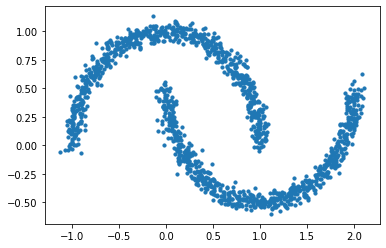

In [ ]:
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
X, y = noisy_moons
plt.scatter(X[:, 0], X[:, 1],  s=10)

<font color='blue'>
<i>
<b>
3. Appliquer l'algorithme K-means avec $k=2$. Qu'observez-vous ? Expliquez pourquoi l'algorithme échoue à reconstituer les clusters sur cet exemple.
</b>
</i>
</font> 

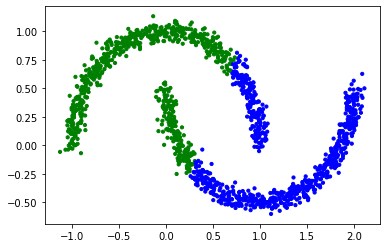

In [ ]:
algorithm = KMeans(n_clusters=2) 
f = algorithm.fit(X)
y_pred = algorithm.predict(X)

plt.scatter(X[:, 0], X[:, 1], s=10, color = colors[y_pred])

Nous introduisons à partir d'ici une nouvelle famille d'algorithme de clustering appelée _Algorithmes à densité_. 

Parmi eux, l'algorithme [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN) proposé par Ester et al. dans [A Density-Based Algorithm for Discovering Clusters
in Large Spatial Databases with Noise](https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf?source=post_page),  utilise deux paramètres : un rayon $\varepsilon$ et un nombre minimum de points $minPts$. 

L’idée de l’algorithme est, pour une donnée $x \in \mathcal{D}$, de  déterminer son $\varepsilon$-voisinage $V_{\varepsilon}(x)$ tel que :

$$V_{\varepsilon}(x)=\{y|y\in \mathcal{D}, d(x,y) < \varepsilon\}$$

Mathématiquement, le voisinage correspond à la boule de rayon $\varepsilon$ autour de l’objetx. On dit alors que le voisinage de $x$ est dense si :

$$|V_{\varepsilon}(x)| \geq minPts$$


Ainsi, pour un objet $x$ donné dont le voisinage est dense, on calcule ensuite le voisinage $V_{\varepsilon}(y)$ pour tout $y\in V_{\varepsilon}(x)$. On continue récursivement et de proche en proche pour tout voisinage dense jusqu'à trouver l’ensemble des objets du cluster.


**Point technique**

- L'algorithme DBSCAN produit des "effets de chainage" des données, pas toujours désirés. 
- Les paramètres $\varepsilon$ et $minPts$ ne sont pas toujours simples à trouver. 
- La complexité de DBSCAN est de l'ordre de $O(n\log(n))$. 


<font color='blue'>
<i>
<b>
4. Quelles techniques proposez-vous afin d'estimer les paramètres $minPts$ et $\varepsilon$ ?
</b>
</i>
</font>

In [ ]:
from sklearn.neighbors import NearestNeighbors

minPts = 4

neighbors = NearestNeighbors(n_neighbors=minPts+1)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)
distances = [np.mean(distances[i, 1:]) for i in range(n_samples)]
distances = sorted(distances, reverse=True)

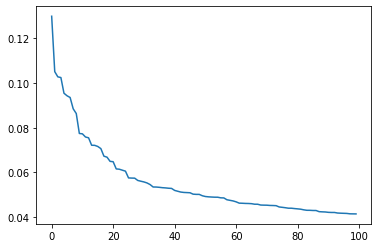

In [ ]:

plt.plot(distances[:100])

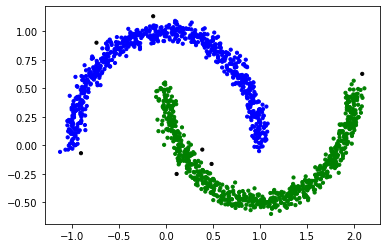

In [ ]:
algorithm = cluster.DBSCAN(eps=.08, min_samples = 4)
f = algorithm.fit(X)
if hasattr(algorithm, 'labels_'):
  y_pred = algorithm.labels_.astype(int)
else:
  y_pred = algorithm.predict(X)

# Affichage des clusters
plt.scatter(X[:, 0], X[:, 1], s=10, color = colors[y_pred])

<font color='blue'>
<i>
<b>
5. Sous hypothèse d'être en dimension $d$ et pour des valeurs $\varepsilon$ et $minPts$ données, par quelle valeur est-il approprié de changer $minPts$ si l'on double la valeur de $\varepsilon$ ?
</b>
</i>
</font>

On considère désormais le jeu de données suivant : 

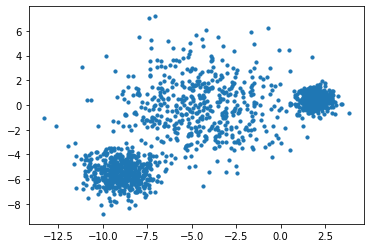

In [ ]:
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1, 2.5, 0.5],
                             random_state=170) 
X, y = varied
plt.scatter(X[:, 0], X[:, 1],  s=10)

<font color='blue'>
<i>
<b>
6. Testez les algorithmes précédents avec les paramètres adéquats. Que remarquez-vous ?
</b>
</i>
</font>


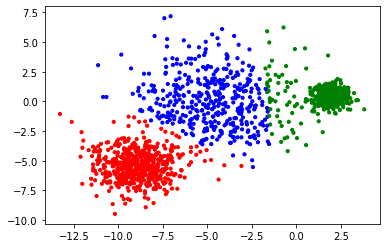

In [ ]:
algorithm = KMeans(n_clusters=3) 
f = algorithm.fit(X)
y_pred = algorithm.predict(X)ù

# Affichage des clusters
plt.scatter(X[:, 0], X[:, 1], s=10, color = colors[y_pred])

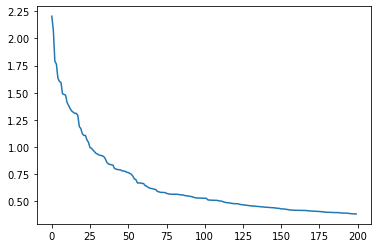

In [ ]:
neighbors = NearestNeighbors(n_neighbors=minPts+1)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)
distances = [np.mean(distances[i, 1:]) for i in range(n_samples)]
distances = sorted(distances, reverse=True)
plt.plot(distances[:200])

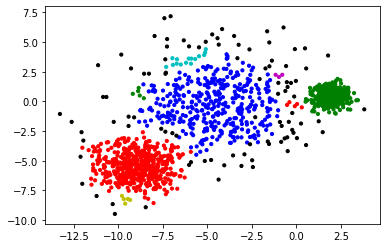

In [ ]:
algorithm = cluster.DBSCAN(eps=0.5, min_samples = 4, metric = 'euclidean',)
f = algorithm.fit(X)
if hasattr(algorithm, 'labels_'):
  y_pred = algorithm.labels_.astype(int)
else:
  y_pred = algorithm.predict(X)

# Affichage des clusters
plt.scatter(X[:, 0], X[:, 1], s=10, color = colors[y_pred])

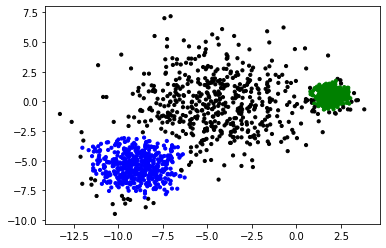

In [ ]:
algorithm = cluster.OPTICS(min_samples = 4, min_cluster_size= .3)

f = algorithm.fit(X)
if hasattr(algorithm, 'labels_'):
  y_pred = algorithm.labels_.astype(int)
else:
  y_pred = algorithm.predict(X)

# Affichage des clusters
plt.scatter(X[:, 0], X[:, 1], s=10, color = colors[y_pred])